# Set-up

## Imports

In [323]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr, binomtest

%load_ext autoreload
%autoreload explicit
%aimport blind_separation
from utils import functional_norm, normalize_curves, month_to_season
from decompose_load import non_blind_separation, decompose_load, decompose_daily_consumption, get_monthly_sectors_consumption
from blind_separation import get_D, get_indicators, get_Y, get_curves_info, process_sector_consumption

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [329]:
# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
train_load_path = 'data/daily_curves_2021_2022.csv'
test_load_path = 'data/daily_curves_2023.csv'
train_results_path = "data/lcnmf_ens.npz"
models_path = train_results_path.replace('.npz', '.pkl')

imser_file = 'data/1_input/indicators/IMSER.xlsx'
imcei_file = 'data/1_input/indicators/IMCEI_mensile.xlsx'
enel_files = [
    'data/1_input/indicators/Domestico 2020 e 2021.xlsx', 
    'data/1_input/indicators/Domestico 2022 e 2023.xlsx'
]
consumption_file = 'data/1_input/consumption/consumption.xlsx'

hue_order = {
    'daytype': ['Monday', 'Working day', 'Saturday', 'Holiday'],
    'season': ['Spring', 'Summer', 'Fall', 'Winter']
}

sectors = ['Domestic', 'Industry', 'Services']

indicator = {
    'Domestic': 'Enel',
    'Industry': 'IMCEI',
    'Services': 'IMSER',
}

sector_alias = {
    'Domestic': 'Household',
    'Industry': 'Industry',
    'Services': 'Services',
}

## Functions

In [507]:
def plot_monthly_cons(Y_pred, Y, sector, train_months, test_months, linewidth=3, figsize=(12, 4), ylim=None, fontsize=18, legend_loc='lower left', plot_naive=False, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(test_months)].reset_index(),
        x='date',
        y=sector,
        color=colors[3],
        label='Predicted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth,
        **kwargs
    )

    sns.lineplot(
        data=Y_pred[Y_pred.index.isin(train_months)].reset_index(),
        x='date',
        y=sector,
        color='grey',
        label='Fitted',
        errorbar='pi',
        ax=ax,
        # marker='o',
        linewidth=linewidth,
        **kwargs
    )

    Y.loc[:, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)

    if plot_naive:
        Y_naive_test = Y.shift(12)[Y.index.isin(test_months)]
        Y_naive_test.loc[:, sector].plot(color=colors[2], label='Naive', ax=ax, linewidth=linewidth)

    if ylim:
        if isinstance(ylim, dict):
            ax.set_ylim(**ylim)
        else:
            ax.set_ylim(ylim)
    ax.set_ylabel('Consumption [GWh]')
    ax.set_xlabel(None, fontsize=fontsize)
    ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=fontsize-2, loc=legend_loc)

    return fig, ax

def plot_monthly_cons_vs_msi(indics_df, Y_pred_ens, sector, test_months, figsize=(6, 3), legend_loc='upper left', primary_ylim=None, secondary_ylim=None, fontsize=18, **kwargs):
    # Filter the series for the year 2023
    Y_pred_ens_test = Y_pred_ens[Y_pred_ens.index.isin(test_months)]
    indics_2023 = indics_df[indics_df.index.isin(test_months)]
    indicator_name = indicator[sector]

    _, ax1 = plt.subplots(figsize=figsize)

    ax1.plot(indics_2023.index, indics_2023[indicator_name], color=colors[0], label=f'MSI ({sector_alias[sector]})', **kwargs)
    ax1.set_ylabel(f'MSI', color=colors[0], fontsize=fontsize)
    ax1.tick_params(axis='y', labelcolor=colors[0], labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    if primary_ylim:
        ax1.set_ylim(primary_ylim)

    # Naive prediction: Enel value for the same month last year
    indics_naive = indics_df[indics_df.index.year == 2022][indicator_name]
    indics_naive.index = indics_naive.index.map(lambda d: d.replace(year=2023))
    ax1.plot(indics_naive.index, indics_naive.values, color=colors[0], linestyle='dotted', label=f'MSI forecast', **kwargs)

    ax2 = ax1.twinx()
    Y_pred_test = Y_pred_ens_test.groupby(Y_pred_ens_test.index)[sectors].mean()
    Y_pred_test = Y_pred_test / 1000
    ax2.plot(Y_pred_test.index, Y_pred_test[sector], color=colors[1], label=f'BSS estimate', linestyle='--', **kwargs)
    ax2.set_ylabel(f'Consumption [TWh]', color=colors[1], fontsize=fontsize)
    ax2.tick_params(axis='y', labelcolor=colors[1], labelsize=fontsize)
    if secondary_ylim:
        ax2.set_ylim(secondary_ylim)
        
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=legend_loc, fontsize=fontsize)
    ax2.grid(False)

    plt.tight_layout()
    plt.show()

def plot_correlation_yoy(yoy_true, yoy_pred_ens, correlation='Pearson', figsize=(15, 4), title=True, interval=False):
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    grouped = yoy_pred_ens.groupby(yoy_pred_ens.index)[sectors]
    yoy_pred = grouped.mean()
    yoy_pred_lower = grouped.quantile(0.025)
    yoy_pred_upper = grouped.quantile(0.975)

    for i, sector in enumerate(sectors):

        x = yoy_true.loc[:, indicator[sector]]
        y = yoy_pred.loc[:, sector]

        # Calculate correlation and p-value
        if correlation == 'Spearman':
            corr, p_value = spearmanr(x, y)
        else:
            corr, p_value = pearsonr(x, y)

        sns.scatterplot(x=x, y=y, ax=axs[i])

        if interval:
            x_lower = yoy_pred_lower.loc[:, sector]
            x_upper = yoy_pred_upper.loc[:, sector]

        if interval:
            for j in range(len(x)):
                axs[i].plot([x.iloc[j], x.iloc[j]], [x_lower.iloc[j], x_upper.iloc[j]], color=colors[0], linewidth=3, alpha=0.5)


        # Set the aspect ratio to be equal
        xlim = axs[i].get_xlim()
        ylim = axs[i].get_ylim()
        new_xylim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
        # new_xylim = (max(xlim[0], ylim[0]), min(xlim[1], ylim[1]))
        axs[i].set_xlim(new_xylim)
        axs[i].set_ylim(new_xylim)

        axs[i].plot([new_xylim[0], new_xylim[1]], [new_xylim[0], new_xylim[1]], color='grey', linestyle='--', linewidth=1, label="y = x")

        # Display correlation and p-value on the plot
        axs[i].text(0.05, 0.95, f'{correlation} $r$ = {corr:.2f}\np-value = {p_value:.3f}', 
                    fontsize=12, ha='left', va='top', transform=axs[i].transAxes)

        # Customize the plot
        # axs[i].set_title(f"Scatter Plot with Pearson Correlation for {year}")
        axs[i].set_xlabel(f"Actual YoY change (%)")
        axs[i].set_ylabel(f"Predicted YoY change (%)")

        axs[i].set_title(f"{sector_alias[sector]}", fontsize=14)

    # Set a common title for all subplots
    if title:
        fig.suptitle(f"{correlation} correlation", fontsize=16)

    # Adjust the layout
    plt.subplots_adjust(wspace=0.3, hspace=0.2)


def plot_profiles(profiles_ens, sector, hue, errorbar=None, palette=None, figsize=(6, 4), fontsize=18, legend_loc='upper left', **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(
        data=profiles_ens.groupby([hue, 'hour', 'model'], as_index=False)[sector].mean(),
        x='hour',
        y=sector,
        errorbar=errorbar,
        ax=ax,
        hue=hue,
        hue_order=hue_order[hue],
        # marker='o',
        linewidth=3,
        palette=palette,
        **kwargs
    )
    # Set a title for the plot
    # ax.set_title(f'Profile for sector {sector}', fontsize=16)
    ax.set_ylim((0,0.065))
    ax.set_ylabel('Normalised Load', fontsize=fontsize)
    ax.legend(title=None, loc=legend_loc, fontsize=fontsize-2)
    ax.set_xlabel('Hour', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
    plt.show()


def plot_decomposed_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)

    for i, sector in enumerate(sectors):
        sns.lineplot(
            data=load_df[(load_df[time_column] >= period[0]) & (load_df[time_column] <= period[1])],
            x=time_column,
            y=sector,
            color=colors[i],
            errorbar='pi',
            ax=ax,
            marker='',
            label=sector_alias[sector],
            linewidth=linewidth,
            **kwargs
        )

    plt.ylim(ylim)

    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize,
                   rotation=45
                   )  # X and Y ticks fontsize

    # Add the legend
    ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize)
    plt.show()


def plot_aggregated_load(load_df, period, time_column, y_label, ylim, figsize=(20, 6), linewidth=3, fontsize=18, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    plot_df = load_df[(load_df[time_column] > period[0]) & (load_df[time_column] < period[1])]
    plot_df['Total load_df'] = plot_df['Domestic'] + plot_df['Industry'] + plot_df['Services']
    sns.lineplot(
        data=plot_df,
        x=time_column,
        y='Total load_df',
        color='grey',
        errorbar=None,
        ax=ax,
        marker='',
        linewidth=linewidth,
        **kwargs
    )
    plt.ylim(ylim)
    ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
    ax.set_ylabel(y_label, fontsize=fontsize)  # Y-axis label fontsize
    ax.tick_params(axis='both', which='major', labelsize=fontsize,
                   rotation=45
                )  # X and Y ticks fontsize
    plt.show()

# Main

## Read data

In [331]:
train_df = pd.read_csv(train_load_path, index_col=0)
test_df = pd.read_csv(test_load_path, index_col=0)
df = pd.concat([train_df, test_df])
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,24.986001,23.811999,21.637000,20.353000,19.526999,19.710000,20.630999,21.374000,21.476001,23.120000,...,26.286000,26.797999,29.402999,30.276001,30.879000,30.785000,29.278000,27.781000,25.231001,22.897000
Italy_2021-01-02_Saturday,22.897000,21.066000,20.098000,19.479001,19.628001,20.179000,22.057000,23.665000,25.416998,27.632999,...,29.591000,30.256001,33.563999,34.974999,35.488000,33.922000,31.566000,29.291000,26.366000,23.792000
Italy_2021-01-03_Holiday,23.792000,21.782999,20.718999,19.991000,19.710998,20.401000,21.539000,22.461000,23.366000,25.735000,...,28.014999,28.608000,31.402001,32.602000,34.002999,33.683000,31.166000,28.950000,26.456999,23.869001
Italy_2021-01-04_Monday,23.869001,21.958999,20.935000,20.653000,20.996000,21.926001,25.264000,30.375001,35.006000,38.855001,...,40.088000,40.025999,42.123001,42.675000,42.545000,40.479002,37.293000,33.952999,30.775001,27.518001
Italy_2021-01-05_Working day,27.518001,25.220001,23.844999,23.238001,23.341001,24.062000,27.387000,32.159999,36.935000,40.043999,...,40.971001,40.879001,43.033000,42.841000,42.022000,40.233000,37.153001,34.007001,30.542000,27.504999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,21.686000,19.714000,18.834000,18.362000,18.458000,19.527000,22.776999,26.962000,30.687999,33.935000,...,33.716999,33.448000,35.718000,36.023000,36.154000,34.695000,32.187000,29.046999,26.000001,23.155001
Italy_2023-12-28_Working day,23.155001,21.268999,20.056001,19.667999,19.638000,20.635000,23.673000,27.638000,31.188998,34.135000,...,33.541000,33.852999,36.306999,36.158000,36.189001,34.751000,32.182001,28.971000,25.710000,22.755001
Italy_2023-12-29_Working day,22.755001,20.792000,19.817999,19.369999,19.352000,20.237999,22.783000,26.304001,29.453000,32.343000,...,31.818000,31.941001,34.263999,34.661000,34.795999,33.152000,30.860000,28.218999,25.332999,22.629000
Italy_2023-12-30_Saturday,22.629000,20.789999,19.718999,19.234000,19.138000,19.780001,21.512001,24.080000,26.029999,28.430001,...,27.979999,28.876998,32.021999,33.344001,34.088999,32.942002,30.398000,28.059000,25.597001,22.839000


In [332]:
# Get train and test period information
test_info = get_curves_info(test_df)
test_months = pd.to_datetime(test_info['year'].astype(str) + '-' + test_info['month'], format='%Y-%m').unique()
train_info = get_curves_info(train_df)
train_months = pd.to_datetime(train_info['year'].astype(str) + '-' + train_info['month'], format='%Y-%m').unique()

# Get information for train + test period
unit_info = get_curves_info(df)

In [333]:
# Load the arrays of the blind separation (train) from the .npz file
data = np.load(train_results_path)
with open(models_path, 'rb') as file:
    model_ens = pickle.load(file)
# Access the arrays
S_ens = data['S_results'] # Could be also retrieved from model_ens
Ctrain_ens = data['C_results'] # Specific to the training data

## Deconvolve load and compute consumption per sectors

Perform non-blind separation of the test (new) data to estimate sources concentrations

In [334]:
X_test = normalize_curves(test_df)
Ctest_ens = non_blind_separation(X_test, model_ens)

  0%|          | 0/271 [00:00<?, ?it/s]

100%|██████████| 271/271 [00:27<00:00,  9.86it/s]


In [335]:
# Put all concentrations together
C_ens = np.concatenate((Ctrain_ens, Ctest_ens), axis=0)

In [336]:
K, p, N = S_ens.shape
h = 24 / (p - 1)
# Daily consumptions
E = unit_info['cons']

In [337]:
decomposed_load = decompose_load(C_ens, S_ens, E)
decomposed_load['Domestic'] = decomposed_load['$S_1$'] + decomposed_load['$S_2$']
decomposed_load['Industry'] = decomposed_load['$S_3$']
decomposed_load['Services'] = decomposed_load['$S_4$'] + decomposed_load['$S_5$']
decomposed_load.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
decomposed_load['date'] = decomposed_load['datetime'].dt.date
decomposed_load['datetime'] = pd.to_datetime(decomposed_load['datetime'])
decomposed_load

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date
0,0,0.0,Italy_2021-01-01_Holiday,2021-01-01 00:00:00,Italy,18.705119,1.618543,4.864571,2021-01-01
1,0,1.0,Italy_2021-01-01_Holiday,2021-01-01 01:00:00,Italy,17.115438,1.513599,4.673273,2021-01-01
2,0,2.0,Italy_2021-01-01_Holiday,2021-01-01 02:00:00,Italy,16.074620,1.456106,4.461372,2021-01-01
3,0,3.0,Italy_2021-01-01_Holiday,2021-01-01 03:00:00,Italy,15.411188,1.435232,4.267510,2021-01-01
4,0,4.0,Italy_2021-01-01_Holiday,2021-01-01 04:00:00,Italy,14.991609,1.435281,4.255245,2021-01-01
...,...,...,...,...,...,...,...,...,...
7418620,270,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,15.673343,1.498228,12.719960,2023-12-31
7418621,270,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,13.872352,1.409798,12.620167,2023-12-31
7418622,270,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,12.979513,1.250958,11.837614,2023-12-31
7418623,270,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,11.896108,1.139348,10.869174,2023-12-31


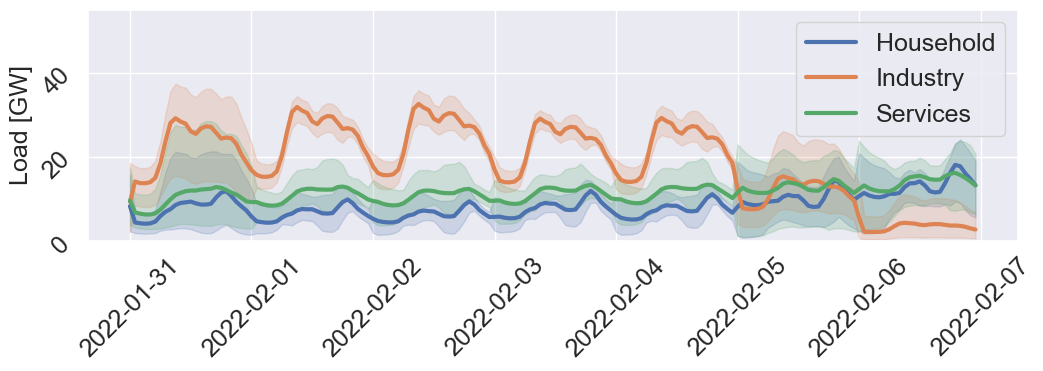

In [508]:
period = ["2022-01-31 00:00:00", "2022-02-06 23:59:00"]
plot_decomposed_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55), fontsize=18, figsize=(12,3), estimator='mean')

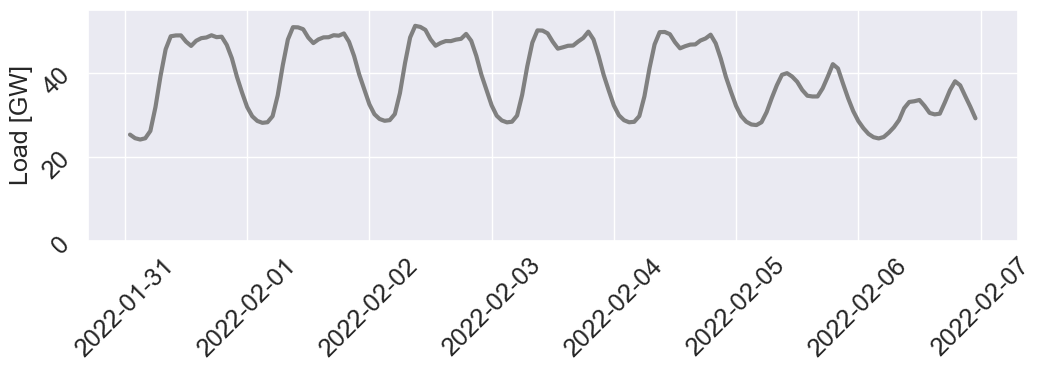

In [339]:
plot_aggregated_load(decomposed_load, period, time_column='datetime', y_label="Load [GW]", ylim=(0, 55), figsize=(12,3))

In [340]:
day_df = decompose_daily_consumption(C_ens, E)
day_df['Domestic'] = day_df['$S_1$'] + day_df['$S_2$']
day_df['Industry'] = day_df['$S_3$']
day_df['Services'] = day_df['$S_4$'] + day_df['$S_5$']
day_df.drop(columns=[f'$S_{k+1}$' for k in range(K)], inplace=True)
day_df['date'] = day_df['date'].astype('datetime64[ns]')
day_df

,model,date,zone,Domestic,Industry,Services
0,0,2021-01-01,Italy,321.428719,47.166828,244.273906
1,1,2021-01-01,Italy,321.771305,14.721201,276.135159
2,2,2021-01-01,Italy,234.314729,15.937776,362.247221
3,3,2021-01-01,Italy,360.681385,7.274812,244.404120
4,4,2021-01-01,Italy,307.676092,10.443864,294.688670
...,...,...,...,...,...,...
296740,266,2023-12-31,Italy,266.738008,22.834661,313.543355
296741,267,2023-12-31,Italy,300.203433,91.740656,211.193840
296742,268,2023-12-31,Italy,271.587620,26.522708,305.084356
296743,269,2023-12-31,Italy,323.986141,45.800406,233.235870


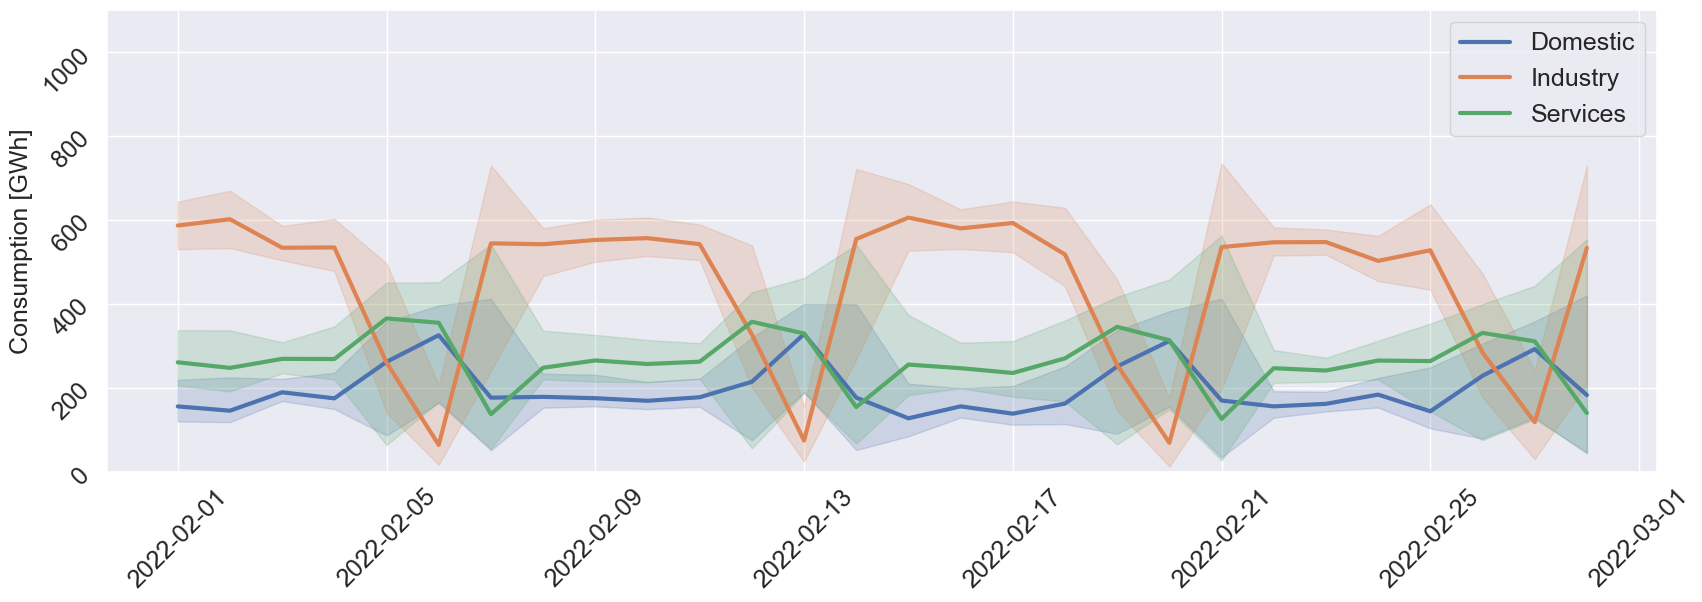

In [341]:
period = ["2022-02-01", "2022-02-28"]
plot_decomposed_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100), estimator='median')

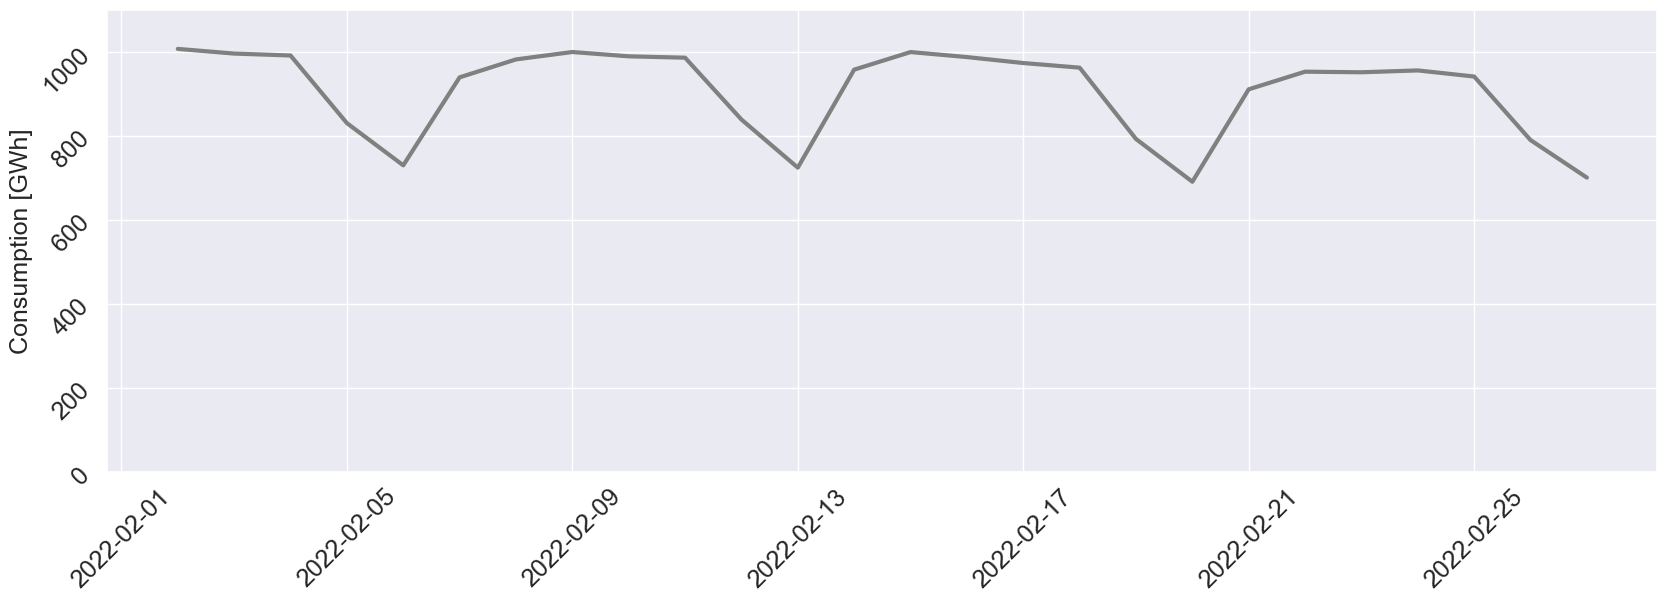

In [342]:
plot_aggregated_load(day_df, period, time_column='date', y_label="Consumption [GWh]", ylim=(0, 1100))

In [343]:
day_df['month'] = pd.to_datetime(day_df['date']).dt.to_period('M')

month_df = day_df.groupby(['month', 'zone', 'model'], as_index=False, sort=False)[sectors].sum()
month_df['year'] = month_df.month.dt.year
month_df

,month,zone,model,Domestic,Industry,Services,year
0,2021-01,Italy,0,6983.155453,11961.809806,8152.404428,2021
1,2021-01,Italy,1,7032.807582,11990.670384,8068.651446,2021
2,2021-01,Italy,2,7080.894040,11906.658060,8097.683975,2021
3,2021-01,Italy,3,7048.798767,11878.273997,8174.733808,2021
4,2021-01,Italy,4,7082.152249,11882.571970,8135.625019,2021
...,...,...,...,...,...,...,...
9751,2023-12,Italy,266,6114.742393,10655.465350,8040.853058,2023
9752,2023-12,Italy,267,6015.723919,11613.045794,7183.195754,2023
9753,2023-12,Italy,268,6132.052240,10778.273867,7900.309339,2023
9754,2023-12,Italy,269,6288.792241,10159.864908,8365.540309,2023


In [344]:
year_df = month_df.groupby(['zone', 'year', 'model'], as_index=False)[sectors].sum()
year_df

,zone,year,model,Domestic,Industry,Services
0,Italy,2021,0,71475.596371,151005.713847,97791.898148
1,Italy,2021,1,71585.819224,151034.828967,97644.049562
2,Italy,2021,2,71708.773741,150952.940330,97568.517520
3,Italy,2021,3,71363.216496,150878.519530,98024.107740
4,Italy,2021,4,71335.199685,150880.993404,98052.277253
...,...,...,...,...,...,...
808,Italy,2023,266,61967.145074,147568.311636,96643.856157
809,Italy,2023,267,63730.695214,146975.655613,95448.368104
810,Italy,2023,268,62006.224079,148726.075254,95434.218446
811,Italy,2023,269,63941.594208,140871.745791,101380.414440


## Test the monthly consumption decomposition with ASC and MSI

In [480]:
year_totals = unit_info.groupby('year')['cons'].sum()
year_month_totals = unit_info.groupby(['year', 'month'])['cons'].sum()

cons_df = process_sector_consumption(consumption_file, year_totals)
indics_df = get_indicators(imser_file, imcei_file, enel_files)
indics_df['Enel'] = indics_df['Enel'] / 50
Y = get_Y(indics_df, cons_df, year_month_totals)
Y.head()

,Domestic,Industry,Services
Mese,,,
2021-01-01,7151.784940,11957.627710,7972.456831
2021-02-01,5797.623636,12058.924649,7122.202247
2021-03-01,6026.656063,13401.703257,7241.288199
2021-04-01,5396.777071,12474.831558,6624.713872
2021-05-01,4912.237452,13123.613499,6945.727551


In [346]:
Y_pred_ens = month_df.copy()
Y_pred_ens = Y_pred_ens.groupby(['year', 'month', 'model'], as_index=False).sum().drop('zone', axis=1)
Y_pred_ens['date'] = Y_pred_ens.month.dt.to_timestamp()
Y_pred_ens.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred_ens.set_index('date', inplace=True)
Y_pred_ens

,model,Domestic,Industry,Services
date,,,,
2021-01-01,0,6983.155453,11961.809806,8152.404428
2021-01-01,1,7032.807582,11990.670384,8068.651446
2021-01-01,2,7080.894040,11906.658060,8097.683975
2021-01-01,3,7048.798767,11878.273997,8174.733808
2021-01-01,4,7082.152249,11882.571970,8135.625019
...,...,...,...,...
2023-12-01,266,6114.742393,10655.465350,8040.853058
2023-12-01,267,6015.723919,11613.045794,7183.195754
2023-12-01,268,6132.052240,10778.273867,7900.309339


(<Figure size 1200x400 with 1 Axes>, <Axes: ylabel='Consumption [GWh]'>)

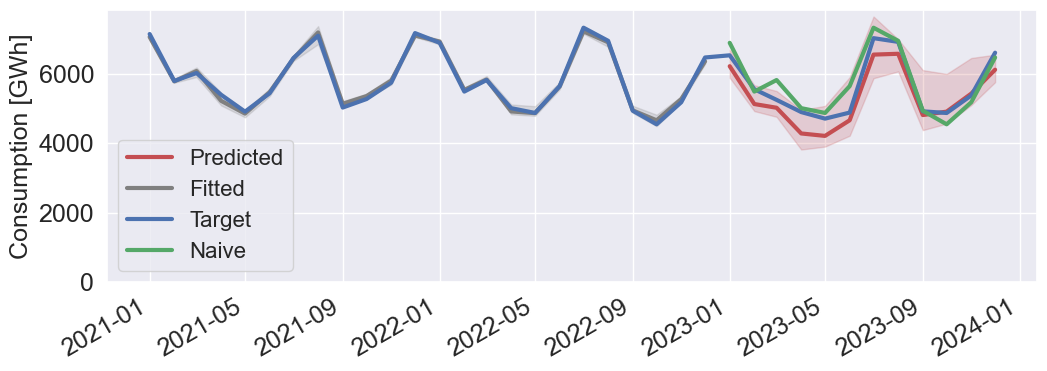

In [419]:
plot_monthly_cons(Y_pred_ens, Y, "Domestic", train_months, test_months, linewidth=3, ylim={'bottom': 0}, plot_naive=True, estimator='mean')

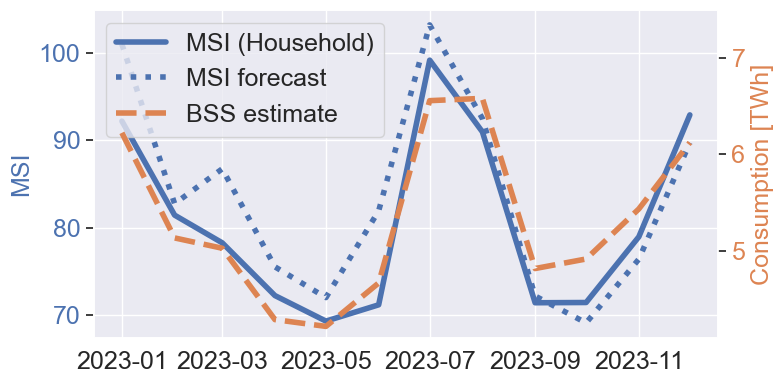

In [510]:
plot_monthly_cons_vs_msi(indics_df, Y_pred_ens, "Domestic", test_months, linewidth=4, secondary_ylim=(None, 7.5), fontsize=18, figsize=(8, 4))

(<Figure size 1200x400 with 1 Axes>, <Axes: ylabel='Consumption [GWh]'>)

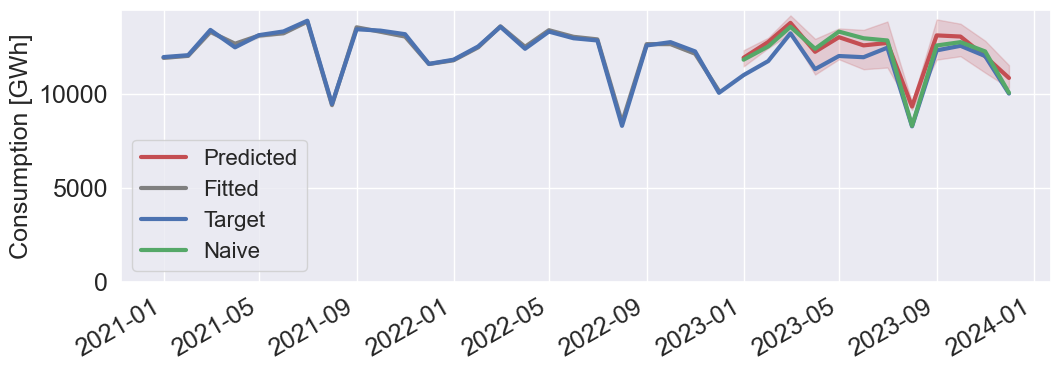

In [348]:
plot_monthly_cons(Y_pred_ens, Y, "Industry", train_months, test_months, ylim={'bottom': 0}, plot_naive=True)

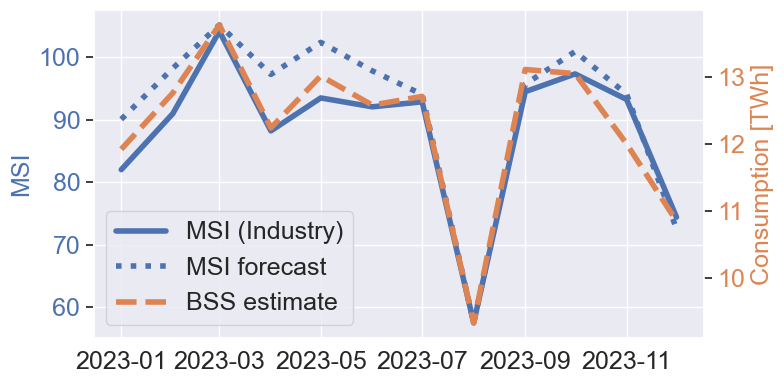

In [509]:
plot_monthly_cons_vs_msi(indics_df, Y_pred_ens, "Industry", test_months, linewidth=4, fontsize=18, figsize=(8, 4), legend_loc='lower left')

(<Figure size 1200x400 with 1 Axes>, <Axes: ylabel='Consumption [GWh]'>)

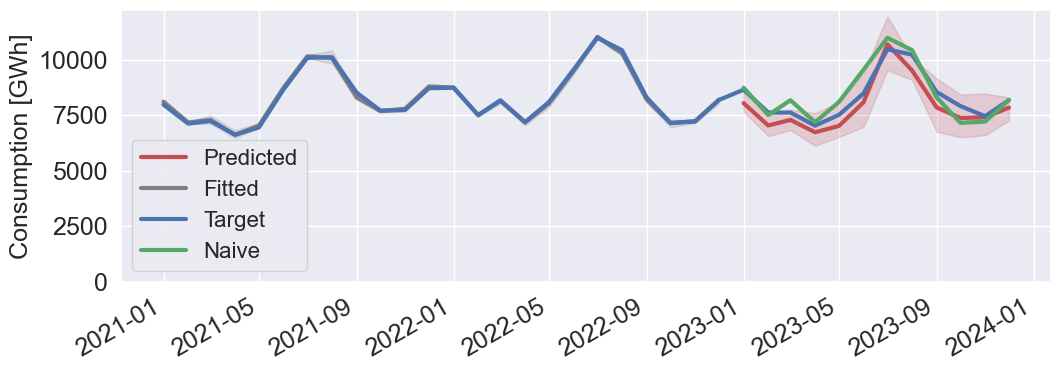

In [349]:
plot_monthly_cons(Y_pred_ens, Y, "Services", train_months, test_months, ylim={'bottom': 0}, plot_naive=True)

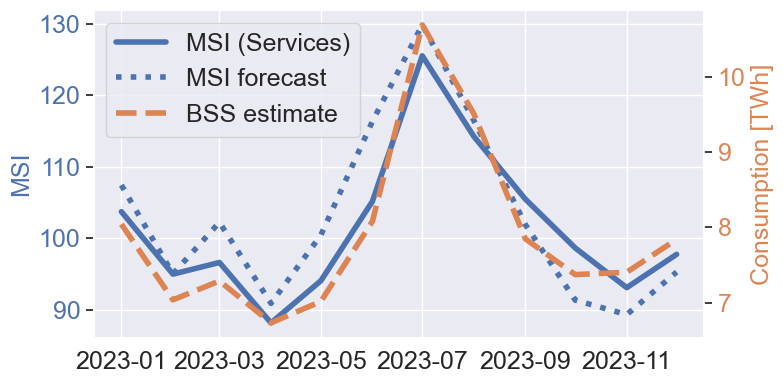

In [511]:
plot_monthly_cons_vs_msi(indics_df, Y_pred_ens, "Services", test_months, linewidth=4, fontsize=18, figsize=(8, 4))

In [433]:
Y_pred_ens_test = Y_pred_ens[Y_pred_ens.index.isin(test_months)]
Y_pred_test = Y_pred_ens_test.groupby(Y_pred_ens_test.index)[sectors].mean()
indics_test = indics_df[indics_df.index.isin(test_months)]
indics_naive = indics_df[indics_df.index.year == 2022]
indics_naive.index = indics_naive.index.map(lambda d: d.replace(year=test_months[0].year))

In [522]:
x_naive

Mese
2023-01-01    107.423182
2023-02-01     95.023857
2023-03-01    102.234518
2023-04-01     90.900558
2023-05-01    100.439128
2023-06-01    116.324823
2023-07-01    129.807110
2023-08-01    116.463829
2023-09-01    101.915127
2023-10-01     91.360256
2023-11-01     89.332645
2023-12-01     95.283398
Name: IMSER, dtype: float64

In [525]:
x

date
2023-01-01     8044.004996
2023-02-01     7037.905488
2023-03-01     7289.490714
2023-04-01     6731.612461
2023-05-01     7017.577084
2023-06-01     8080.496018
2023-07-01    10692.666565
2023-08-01     9512.785498
2023-09-01     7849.111565
2023-10-01     7373.648330
2023-11-01     7405.202276
2023-12-01     7842.430677
Name: Services, dtype: float64

In [533]:
sector = 'Domestic'
y = indics_test.loc[:, indicator[sector]]
x1 = Y_pred_test.loc[:, sector]
x2 = indics_naive.loc[:, indicator[sector]]
n = len(y)
rng = np.random.default_rng(None)
mask = rng.integers(0, 2, size=n)
sample1 = np.where(mask, x1, x2)
sample2 = np.where(mask, x2, x1)
print(sample1, sample2)

[5048.11421308 5131.73677381 4336.18177666 4282.97248256 3600.34399886
 4096.01107594 6557.99476328 4623.82321149 3609.39475266 3455.65178893
 5432.99294306 6122.66029083] [6223.74336727 4137.00363127 5024.42331857 3776.0861502  4212.30832893
 4663.65824219 5158.76551385 6581.85519622 4813.59995075 4912.97369084
 3820.14724617 4485.0888779 ]


In [534]:
def hybrid_permutation_corr_test(x1, x2, y, n_permutations=1000, seed=None, plot=True):
    rng = np.random.default_rng(seed)
    n = len(x1)

    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    y = np.asarray(y)

    # Standardize x1 and x2
    x1 = (x1 - np.mean(x1)) / np.std(x1)
    x2 = (x2 - np.mean(x2)) / np.std(x2)

    # Observed correlation difference
    r1, _ = pearsonr(x1, y)
    r2, _ = pearsonr(x2, y)
    observed_diff = abs(r1 - r2)

    diffs = []

    for _ in range(n_permutations):
        mask = rng.integers(0, 2, size=n)
        sample1 = np.where(mask, x1, x2)
        sample2 = np.where(mask, x2, x1)

        pr1, _ = pearsonr(sample1, y)
        pr2, _ = pearsonr(sample2, y)
        diffs.append(pr1 - pr2)

    diffs = np.array(diffs)
    p_value = np.mean(diffs >= observed_diff)

    # Plotting the null distribution
    if plot:
        plt.figure(figsize=(8, 4))
        plt.hist(diffs, bins=50, color='lightgray', edgecolor='black', density=True)
        plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2,
                    label=f'Observed diff = {observed_diff:.3f}')
        plt.title("Null Distribution of Correlation Differences", fontsize=14)
        plt.xlabel("r(x1, y) - r(x2, y)", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return observed_diff, p_value

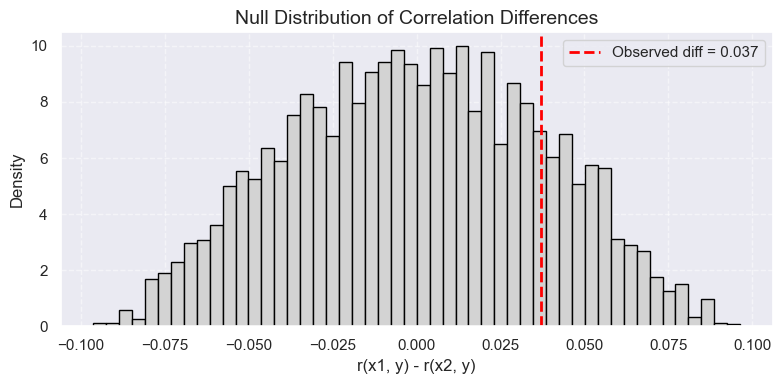

0.0369644642408149


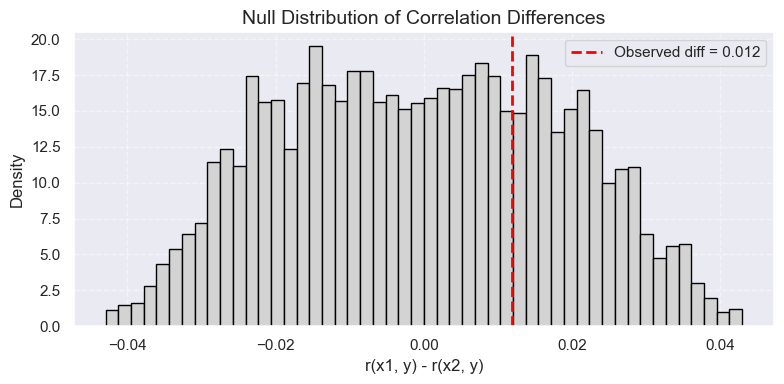

0.011915271858311982


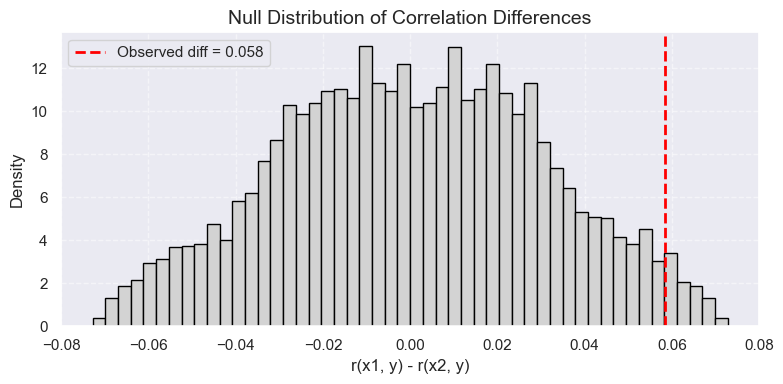

0.058387128938021116


,Y-1,BSS,p-value
Domestic,0.914,0.951,0.1822
Industry,0.962,0.974,0.2977
Services,0.912,0.97,0.0252


In [536]:
corr_df = pd.DataFrame(index=sectors, columns=['Y-1', 'BSS', 'p-value'])
for sector in sectors:
    y = indics_test.loc[:, indicator[sector]]
    x = Y_pred_test.loc[:, sector]

    # Calculate correlation and p-value
    corr, _ = pearsonr(x, y)
    corr_df.loc[sector, 'BSS'] = round(corr, 3)

    x_naive = indics_naive.loc[:, indicator[sector]]
    corr_naive, _ = pearsonr(x_naive, y)
    corr_df.loc[sector, 'Y-1'] = round(corr_naive, 3)

    obs_diff, p_val = hybrid_permutation_corr_test(x, x_naive, y, n_permutations=10000)
    print(obs_diff)
    corr_df.loc[sector, 'p-value'] = p_val

corr_df

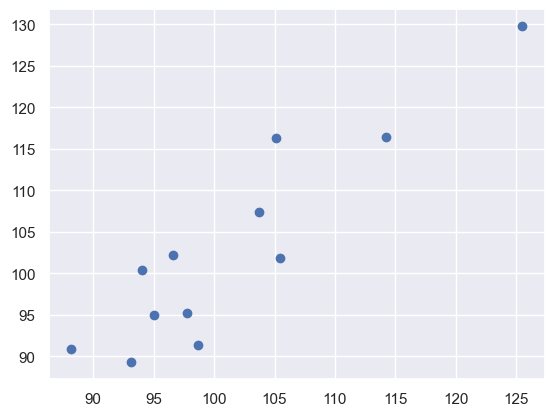

In [446]:
sector = 'Services'
x = indics_test.loc[:, indicator[sector]]
x_naive = indics_naive.loc[:, indicator[sector]]
y = Y_pred_test.loc[:, sector]
plt.plot(x, x_naive, 'o', color=colors[0], label='BSS estimate')
# plt.plot(x, x_naive, 'o', color=colors[1], label='Naive estimate')

In [222]:
grouped = Y_pred_ens.groupby(Y_pred_ens.index)[sectors]
Y_pred = grouped.mean()
Y_pred_lower = grouped.quantile(0.025)
Y_pred_upper = grouped.quantile(0.975)

In [223]:
hits = (Y > Y_pred_lower) & (Y < Y_pred_upper)
hits = hits[hits.index.isin(test_months)]
hits

,Domestic,Industry,Services
Mese,,,
2024-01-01,True,False,False
2024-02-01,False,True,True
2024-03-01,False,True,True
2024-04-01,True,True,True
2024-05-01,True,True,True
2024-06-01,False,True,True
2024-07-01,False,True,True
2024-08-01,False,False,True
2024-09-01,False,True,True


In [224]:
hits.sum().apply(lambda k: binomtest(k, n=len(test_months), p=0.95).pvalue)

Domestic    4.949005e-07
Industry    1.956826e-02
Services    4.596399e-01
dtype: float64

In [225]:
hits.sum().apply(lambda k: binomtest(k, n=len(test_months), p=0.95).statistic)

Domestic    0.416667
Industry    0.750000
Services    0.916667
dtype: float64

In [226]:
hits.sum().apply(lambda k: binomtest(k, n=len(test_months), p=0.95).proportion_ci(confidence_level=0.95, method='exact'))

Domestic    (0.15165222980843474, 0.7233303143178942)
Industry    (0.42814153812190026, 0.9451393554720076)
Services     (0.6152038348490562, 0.9978924067681384)
dtype: object

In [227]:
hits.size

36

In [228]:
result = binomtest(hits.sum().sum(), n=hits.size, p=0.95)
# Pretty print the result
print("🔍 Binomial Test Summary")
print("-" * 30)
print(f"Successes (k):      {result.k}")
print(f"Trials (n):         {result.n}")
print(f"Frequency:         {result.statistic:.2f}")
print(f"Alternative:        {result.alternative}")
print(f"P-value:            {result.pvalue:.4f}")
print(f"Confidence interval: {result.proportion_ci(confidence_level=0.95)}")

🔍 Binomial Test Summary
------------------------------
Successes (k):      25
Trials (n):         36
Frequency:         0.69
Alternative:        two-sided
P-value:            0.0000
Confidence interval: ConfidenceInterval(low=0.518929369999942, high=0.8365260153715062)


Test if the %YoY variations in the test set are consistent with those of the indicators, to show that we just don't catch some simple seaonality

In [309]:
df_list = []

for model in Y_pred_ens.model.unique():
    pct_change = Y_pred_ens.loc[Y_pred_ens.model == model].pct_change(periods=12)*100
    pct_change = pct_change[pct_change.index.isin(test_months)]
    pct_change['model'] = model
    df_list.append(pct_change)

yoy_pred_ens_test = pd.concat(df_list, ignore_index=False)
yoy_pred_ens_test

,model,Domestic,Industry,Services
date,,,,
2024-01-01,0,-6.724289,11.281145,-2.778503
2024-02-01,0,-3.097465,8.494189,-6.490486
2024-03-01,0,11.780256,-8.021272,2.164085
2024-04-01,0,5.722533,-13.780927,20.572339
2024-05-01,0,3.172265,-7.108141,15.637923
...,...,...,...,...
2024-08-01,207,0.181512,13.997124,10.524518
2024-09-01,207,-2.696189,4.015137,-6.088311
2024-10-01,207,4.364311,1.533528,-3.083571


In [318]:
yoy_true = Y.pct_change(periods=12) * 100
yoy_true_test = yoy_true[yoy_true.index.isin(test_months)]
yoy_true_test.columns = [indicator[sector] for sector in yoy_true_test.columns]
yoy_true_test

,Enel,IMCEI,IMSER
Mese,,,
2024-01-01,-5.998514,6.181469,3.179415
2024-02-01,-11.838347,6.020124,3.230896
2024-03-01,-3.657365,-3.049140,2.328163
2024-04-01,-9.502337,3.496421,2.577622
2024-05-01,-6.104473,4.465509,2.642256
2024-06-01,-9.062739,5.639313,1.033574
2024-07-01,3.228371,6.405046,2.918610
2024-08-01,11.986049,5.130260,6.986087
2024-09-01,4.993431,-0.915882,-3.226330


In [319]:
grouped = yoy_pred_ens_test.groupby(yoy_pred_ens_test.index)[sectors]
yoy_pred = grouped.mean()
yoy_pred_lower = grouped.quantile(0.025)
yoy_pred_upper = grouped.quantile(0.975)

In [320]:
df_list = []

for model in Y_pred_ens.model.unique():
    pct_change = Y_pred_ens.loc[Y_pred_ens.model == model].pct_change(periods=12)*100
    pct_change = pct_change[pct_change.index.isin(test_months)]
    pct_change['model'] = model
    df_list.append(pct_change)

Y_pred_pct_change = pd.concat(df_list, ignore_index=False)
Y_pred_pct_change

,model,Domestic,Industry,Services
date,,,,
2024-01-01,0,-6.724289,11.281145,-2.778503
2024-02-01,0,-3.097465,8.494189,-6.490486
2024-03-01,0,11.780256,-8.021272,2.164085
2024-04-01,0,5.722533,-13.780927,20.572339
2024-05-01,0,3.172265,-7.108141,15.637923
...,...,...,...,...
2024-08-01,207,0.181512,13.997124,10.524518
2024-09-01,207,-2.696189,4.015137,-6.088311
2024-10-01,207,4.364311,1.533528,-3.083571


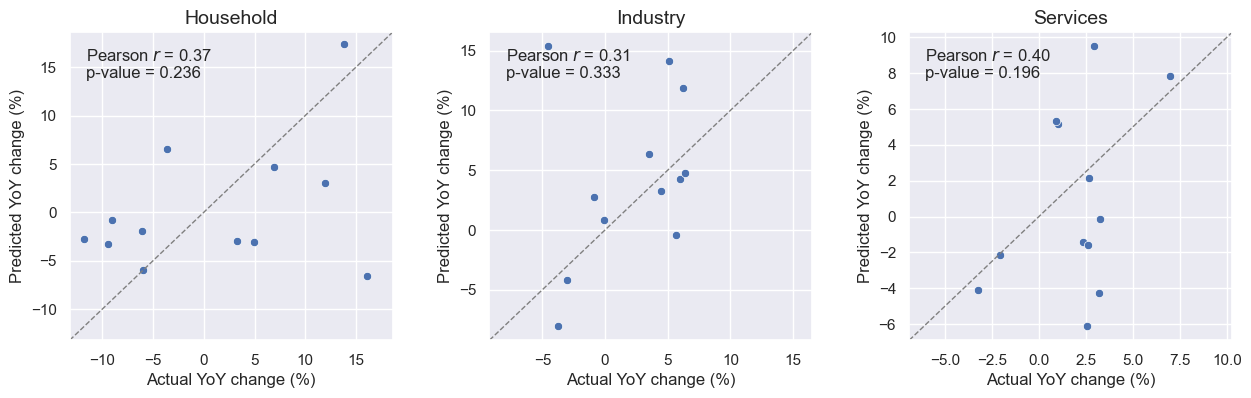

In [321]:
plot_correlation_yoy(yoy_true_test, yoy_pred_ens_test, correlation='Pearson', figsize=(15, 4), title=False, interval=False)

## Analyse sector load profiles

In [28]:
# Normalise the decomposed load to easily retrieve the profiles
D = get_D(p)
norms = decomposed_load.reset_index().groupby(['obs', 'model'], as_index=False, sort=False)[sectors].agg(lambda a: a.dot(D.squeeze()))
profiles = decomposed_load.copy()
profiles[sectors] = profiles[sectors] /  np.repeat(norms[sectors], repeats=p, axis=0)
profiles[unit_info.columns] = np.repeat(unit_info, repeats=p*N, axis=0)
profiles

,model,hour,obs,datetime,zone,Domestic,Industry,Services,date,region,year,month,daytype,cons,season
0,0,0.0,Italy_2021-01-01_Holiday,2021-01-01 00:00:00,Italy,0.058197,0.034319,0.019914,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
1,0,1.0,Italy_2021-01-01_Holiday,2021-01-01 01:00:00,Italy,0.053251,0.032094,0.019131,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
2,0,2.0,Italy_2021-01-01_Holiday,2021-01-01 02:00:00,Italy,0.050013,0.030875,0.018264,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
3,0,3.0,Italy_2021-01-01_Holiday,2021-01-01 03:00:00,Italy,0.047948,0.030432,0.017470,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
4,0,4.0,Italy_2021-01-01_Holiday,2021-01-01 04:00:00,Italy,0.046643,0.030433,0.017420,2021-01-01,Italy,2021,01,Holiday,612.349503,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7418620,270,20.0,Italy_2023-12-31_Holiday,2023-12-31 20:00:00,Italy,0.052711,0.045140,0.046657,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418621,270,21.0,Italy_2023-12-31_Holiday,2023-12-31 21:00:00,Italy,0.046654,0.042475,0.046291,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418622,270,22.0,Italy_2023-12-31_Holiday,2023-12-31 22:00:00,Italy,0.043652,0.037690,0.043420,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall
7418623,270,23.0,Italy_2023-12-31_Holiday,2023-12-31 23:00:00,Italy,0.040008,0.034327,0.039868,2023-12-31,Italy,2023,12,Holiday,602.807502,Fall


In [29]:
profiles_ens = profiles.groupby(unit_info.columns.to_list() + ['model', 'hour'], as_index=False, sort=False)[sectors].mean()
profiles_ens

,region,year,month,daytype,cons,season,model,hour,Domestic,Industry,Services
0,Italy,2021,01,Holiday,612.349503,Winter,0,0.0,0.058197,0.034319,0.019914
1,Italy,2021,01,Holiday,612.349503,Winter,0,1.0,0.053251,0.032094,0.019131
2,Italy,2021,01,Holiday,612.349503,Winter,0,2.0,0.050013,0.030875,0.018264
3,Italy,2021,01,Holiday,612.349503,Winter,0,3.0,0.047948,0.030432,0.017470
4,Italy,2021,01,Holiday,612.349503,Winter,0,4.0,0.046643,0.030433,0.017420
...,...,...,...,...,...,...,...,...,...,...,...
7418620,Italy,2023,12,Holiday,602.807502,Fall,270,20.0,0.052711,0.045140,0.046657
7418621,Italy,2023,12,Holiday,602.807502,Fall,270,21.0,0.046654,0.042475,0.046291
7418622,Italy,2023,12,Holiday,602.807502,Fall,270,22.0,0.043652,0.037690,0.043420
7418623,Italy,2023,12,Holiday,602.807502,Fall,270,23.0,0.040008,0.034327,0.039868


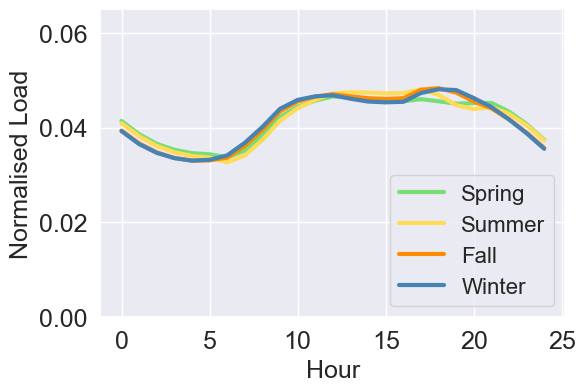

In [55]:
sector = 'Services'
hue = 'season'

palette = {
    'season': ['#77dd77', '#ffdb58', '#FF8C00', '#4682B4'],
    'daytype': [plasma(value) for value in np.linspace(0, 0.9, 4)]
}

plot_profiles(profiles_ens, sector, hue, errorbar=None, palette=palette[hue], legend_loc='lower right')

## Export results

In [94]:
Y_pred_test = Y_pred[Y_pred.index.isin(test_months)]
Y_hat_test = Y_hat[Y_hat.index.isin(test_months)]
Y_hat_test.to_csv('data/sector_monthly_cons_mean.csv')
Y_pred_test.to_csv('data/sector_monthly_cons_distrib.csv')

<HR>

# TESTS

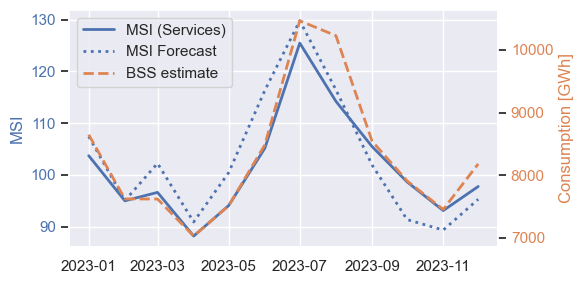

In [ ]:
load_2021_2022 = pd.read_csv('data/load.csv', index_col=0)
load_2021 = load_2021_2022[load_2021_2022.index <= '2022-01-01 00:00:00']
load_2021.to_csv('data/load_2021.csv')

In [113]:
load_2022 = load_2021_2022[load_2021_2022.index >= '2022-01-01 00:00:00']
load_2022.to_csv('data/load_2022.csv')

In [63]:
load_2023 = pd.read_csv('data/load_2023.csv', index_col=0)
load_2021_2022_2023 = pd.concat([load_2023, load_2021_2022[load_2021_2022.index < '2023-01-01 00:00:00']], ignore_index=False)
load_2022_2023 = load_2021_2022_2023[load_2021_2022_2023.index >= '2022-01-01 00:00:00']
load_2022_2023.to_csv('data/load_2022_2023.csv')

In [245]:
load_2023 = pd.read_csv('data/load_2023.csv', index_col=0)
load_2024 = pd.read_csv('data/load_2024.csv', index_col=0).drop(['date_tz', 'date_offset'], axis=1)
load_2023_2024 = pd.concat([load_2024, load_2023[load_2023.index < '2024-01-01 00:00:00']], ignore_index=False)
load_2023_2024.to_csv('data/load_2023_2024.csv')
load_2023_2024

,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
Date,,,
2025-01-01 00:00:00,24928.999,24212.000,Italy
2025-01-01 00:00:00,530.625,515.364,Calabria
2025-01-01 00:00:00,2115.609,2054.760,Centre-North
2025-01-01 00:00:00,4621.470,4488.549,Centre-South
2025-01-01 00:00:00,12422.927,12065.623,North
...,...,...,...
2023-01-01 00:00:00,4378.518,4575.357,Centre-South
2023-01-01 00:00:00,21954.999,22942.000,Italy
2023-01-01 00:00:00,10953.163,11445.569,North


In [177]:
load_2021_2022_2023

,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
Date,,,
2024-01-01 00:00:00,1497.560,1507.008,South
2024-01-01 00:00:00,541.531,544.948,Calabria
2024-01-01 00:00:00,1954.746,1967.078,Centre-North
2024-01-01 00:00:00,4695.334,4724.956,Centre-South
2024-01-01 00:00:00,22508.000,22650.000,Italy
...,...,...,...
2021-01-01 00:00:00,1015.508,1003.965,Sardinia
2021-01-01 00:00:00,12206.546,12067.801,North
2021-01-01 00:00:00,24986.001,24701.999,Italy


In [178]:
load_2021_2022_2023.to_csv('data/load_2021_2022_2023.csv')

In [60]:
load_2021

,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
Date,,,
2022-01-01 00:00:00,2128.211,2143.408,South
2022-01-01 00:00:00,517.788,521.486,Calabria
2022-01-01 00:00:00,2137.642,2152.907,Centre-North
2022-01-01 00:00:00,4604.775,4637.657,Centre-South
2022-01-01 00:00:00,24227.000,24400.001,Italy
...,...,...,...
2021-01-01 00:00:00,1015.508,1003.965,Sardinia
2021-01-01 00:00:00,12206.546,12067.801,North
2021-01-01 00:00:00,24986.001,24701.999,Italy


In [86]:
load_2021_2023 = load_2021_2022_2023[(load_2021_2022_2023.index <= '2022-01-01 00:00:00') | (load_2021_2022_2023.index >= '2023-01-01 00:00:00')]
load_2021_2023.to_csv('data/load_2021_2023.csv')
load_2021_2023

,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
Date,,,
2024-01-01 00:00:00,1497.560,1507.008,South
2024-01-01 00:00:00,541.531,544.948,Calabria
2024-01-01 00:00:00,1954.746,1967.078,Centre-North
2024-01-01 00:00:00,4695.334,4724.956,Centre-South
2024-01-01 00:00:00,22508.000,22650.000,Italy
...,...,...,...
2021-01-01 00:00:00,1015.508,1003.965,Sardinia
2021-01-01 00:00:00,12206.546,12067.801,North
2021-01-01 00:00:00,24986.001,24701.999,Italy


In [103]:
load_2021_2023[(load_2021_2023.Bidding_Zone == 'Italy') & (load_2021_2023.index >= "2022-12-31 23:00:00")]

,Total_Load_MW,Forecast_Total_Load_MW,Bidding_Zone
Date,,,
2024-01-01 00:00:00,22508.000,22650.000,Italy
2023-12-31 23:45:00,22922.000,22707.999,Italy
2023-12-31 23:30:00,23349.999,23027.001,Italy
2023-12-31 23:15:00,23732.000,23346.000,Italy
2023-12-31 23:00:00,24129.000,23703.000,Italy
...,...,...,...
2023-01-01 01:00:00,21214.999,21322.000,Italy
2023-01-01 00:45:00,21400.000,21735.000,Italy
2023-01-01 00:30:00,21548.000,22175.001,Italy


In [106]:
daily_curves_2021 = pd.read_csv('data/daily_curves_2021.csv', index_col=0)
daily_curves_2023 = pd.read_csv('data/daily_curves_2023.csv', index_col=0)
daily_curves_2021_2023 = pd.concat([daily_curves_2021, daily_curves_2023], ignore_index=False)
daily_curves_2021_2023.to_csv('data/daily_curves_2021_2023.csv')
daily_curves_2021_2023

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,24.986001,23.811999,21.637000,20.353000,19.526999,19.710000,20.630999,21.374000,21.476001,23.120000,...,26.286000,26.797999,29.402999,30.276001,30.879000,30.785000,29.278000,27.781000,25.231001,22.897000
Italy_2021-01-02_Saturday,22.897000,21.066000,20.098000,19.479001,19.628001,20.179000,22.057000,23.665000,25.416998,27.632999,...,29.591000,30.256001,33.563999,34.974999,35.488000,33.922000,31.566000,29.291000,26.366000,23.792000
Italy_2021-01-03_Holiday,23.792000,21.782999,20.718999,19.991000,19.710998,20.401000,21.539000,22.461000,23.366000,25.735000,...,28.014999,28.608000,31.402001,32.602000,34.002999,33.683000,31.166000,28.950000,26.456999,23.869001
Italy_2021-01-04_Monday,23.869001,21.958999,20.935000,20.653000,20.996000,21.926001,25.264000,30.375001,35.006000,38.855001,...,40.088000,40.025999,42.123001,42.675000,42.545000,40.479002,37.293000,33.952999,30.775001,27.518001
Italy_2021-01-05_Working day,27.518001,25.220001,23.844999,23.238001,23.341001,24.062000,27.387000,32.159999,36.935000,40.043999,...,40.971001,40.879001,43.033000,42.841000,42.022000,40.233000,37.153001,34.007001,30.542000,27.504999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-27_Working day,21.686000,19.714000,18.834000,18.362000,18.458000,19.527000,22.776999,26.962000,30.687999,33.935000,...,33.716999,33.448000,35.718000,36.023000,36.154000,34.695000,32.187000,29.046999,26.000001,23.155001
Italy_2023-12-28_Working day,23.155001,21.268999,20.056001,19.667999,19.638000,20.635000,23.673000,27.638000,31.188998,34.135000,...,33.541000,33.852999,36.306999,36.158000,36.189001,34.751000,32.182001,28.971000,25.710000,22.755001
Italy_2023-12-29_Working day,22.755001,20.792000,19.817999,19.369999,19.352000,20.237999,22.783000,26.304001,29.453000,32.343000,...,31.818000,31.941001,34.263999,34.661000,34.795999,33.152000,30.860000,28.218999,25.332999,22.629000
Italy_2023-12-30_Saturday,22.629000,20.789999,19.718999,19.234000,19.138000,19.780001,21.512001,24.080000,26.029999,28.430001,...,27.979999,28.876998,32.021999,33.344001,34.088999,32.942002,30.398000,28.059000,25.597001,22.839000


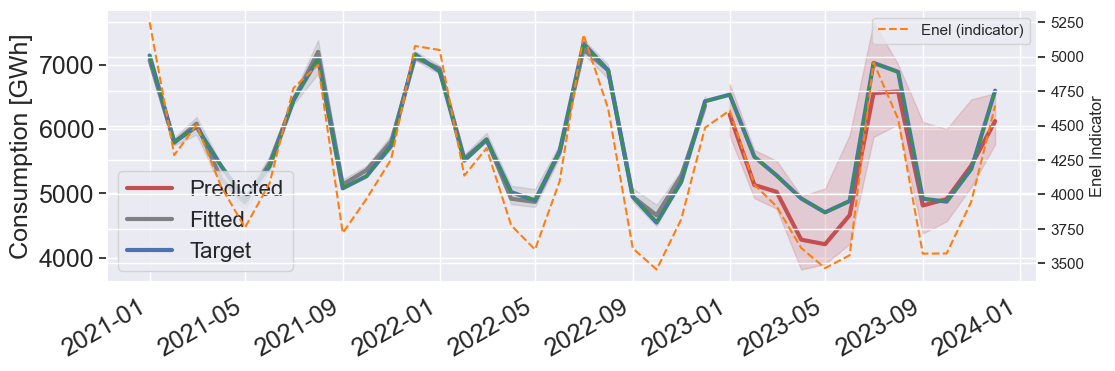

In [199]:
fig, ax = plot_monthly_cons(Y_pred_ens, Y, "Domestic", train_months, test_months, linewidth=3, plot_naive=False)
# Add Enel indicator as a secondary y-axis
ax2 = ax.twinx()
ax2.plot(Y.index, indics_df.loc[Y.index, 'Enel'], color='tab:orange', linestyle='--', label='Enel (indicator)')
ax.plot(Y.index, Y.loc[:, 'Domestic'], color='tab:green', linestyle='--', label='Enel (indicator)')
ax2.set_ylabel('Enel Indicator')
ax2.legend(loc='upper right')
# ax.right_ax.set_ylabel('Enel Indicator')
# ax.right_ax.legend(loc='upper right')

In [189]:
indics_df.loc[:, 'Enel'].index.equals(Y.index)

False

In [190]:
Y.index

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Mese', freq=None)

In [186]:
indics_df

,IMCEI,IMSER,Enel
Mese,,,
2020-01-01,95.501727,6767.710901,4741.474351
2020-02-01,102.158558,6108.615709,4120.931091
2020-03-01,83.918607,5072.078974,4571.397146
2020-04-01,67.621478,4106.738593,4056.375574
2020-05-01,98.087167,4941.189899,3817.225967
2020-06-01,98.441420,5861.144890,3712.291417
2020-07-01,105.692110,7508.954959,4493.444176
2020-08-01,67.808602,7396.750977,4878.716921
2020-09-01,104.167368,6717.073948,3832.196697


<Axes: >

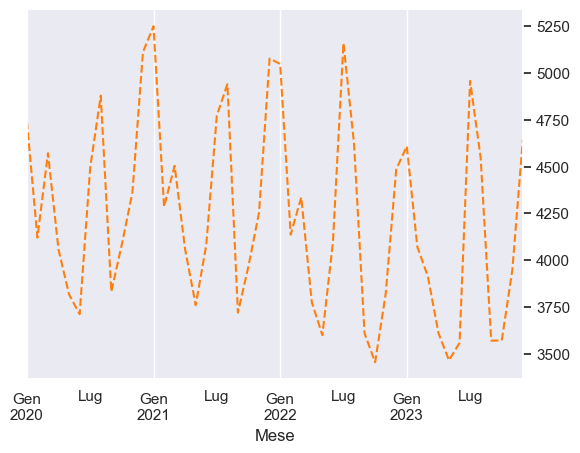

In [184]:
indics_df.loc[:,'Enel'].plot(secondary_y=True, color='tab:orange', style='--', label='Enel (indicator)')

In [176]:
indics_df

,IMCEI,IMSER,Enel
Mese,,,
2020-01-01,95.501727,6767.710901,4741.474351
2020-02-01,102.158558,6108.615709,4120.931091
2020-03-01,83.918607,5072.078974,4571.397146
2020-04-01,67.621478,4106.738593,4056.375574
2020-05-01,98.087167,4941.189899,3817.225967
2020-06-01,98.441420,5861.144890,3712.291417
2020-07-01,105.692110,7508.954959,4493.444176
2020-08-01,67.808602,7396.750977,4878.716921
2020-09-01,104.167368,6717.073948,3832.196697


In [22]:
Y

,Domestic,Industry,Services
Mese,,,
2021-01-01,7140.915027,11919.077661,8021.876794
2021-02-01,5798.208878,12027.588273,7152.953381
2021-03-01,6034.945900,13395.272065,7239.429554
2021-04-01,5426.688341,12536.637147,6532.997014
2021-05-01,4902.511816,13091.845812,6987.220874
2021-06-01,5422.083542,13273.770662,8726.013316
2021-07-01,6449.235365,13880.930491,10103.689659
2021-08-01,7093.269686,9495.985836,10081.852017
2021-09-01,5079.594569,13586.250458,8319.998966


In [230]:
Y_naive_test = Y.shift(12)[Y.index.isin(test_months)]
Y_naive_test

,Domestic,Industry,Services
Mese,,,
2024-01-01,6937.439227,10774.036679,8471.042077
2024-02-01,5214.214607,11953.735917,7758.344454
2024-03-01,4514.009496,13688.343913,7891.269560
2024-04-01,4453.909559,11590.749371,7201.797063
2024-05-01,4272.339261,12284.173173,7682.808569
2024-06-01,4634.080192,12097.188595,8588.388182
2024-07-01,7501.617985,12201.958817,10249.478187
2024-08-01,8546.201868,7548.559039,9329.561613
2024-09-01,4748.208279,12415.223260,8614.284445


In [231]:
Y_test = Y[Y.index.isin(test_months)]
pve_naive = 1 - ((Y_naive_test - Y_test)**2).mean() / ((Y_test - Y_test.mean())**2).mean()
mape_naive = (np.abs((Y_naive_test - Y_test) / Y_test)).mean() * 100
pve_naive
# mape_naive.map(lambda x: f"{x:.1f} %")

Domestic    0.894737
Industry    0.887121
Services    0.904725
dtype: float64

In [232]:
Y_pred_test = Y_pred.groupby(Y_pred.index)[sectors].mean()[Y.index.isin(test_months)]
pve_pred = 1 - ((Y_pred_test - Y_test)**2).mean() / ((Y_test - Y_test.mean())**2).mean()
mape_pred = (np.abs((Y_pred_test - Y_test) / Y_test)).mean() * 100
pve_pred
# mape_pred.map(lambda x: f"{x:.1f} %")

Domestic    0.881714
Industry    0.777848
Services    0.805378
dtype: float64

In [41]:
Y_pred_test = Y_pred.groupby(Y_pred.index)[sectors].mean()[Y.index.isin(test_months)]
Y_pred_test

,Domestic,Industry,Services
date,,,
2023-01-01,6223.743367,11920.386830,8044.004996
2023-02-01,5131.736774,12760.657402,7037.905488
2023-03-01,5024.423319,13777.105360,7289.490714
2023-04-01,4282.972483,12239.008801,6731.612461
2023-05-01,4212.308329,13015.038679,7017.577084
2023-06-01,4663.658242,12579.492335,8080.496018
2023-07-01,6557.994763,12709.799795,10692.666565
2023-08-01,6581.855196,9327.271495,9512.785498
2023-09-01,4813.599951,13111.453598,7849.111565


In [24]:
Y_pred_point = Y_pred.groupby(Y_pred.index)[sectors].mean()
Y_pred_point

,Domestic,Industry,Services
date,,,
2021-01-01,7066.478671,11914.831150,8109.517252
2021-02-01,5785.448642,12021.065703,7169.861053
2021-03-01,6084.359503,13297.716604,7291.009313
2021-04-01,5223.636647,12669.273203,6611.183019
2021-05-01,4855.840365,13102.175916,7030.226800
2021-06-01,5473.584123,13223.978152,8735.646624
2021-07-01,6442.914030,13842.055439,10152.585979
2021-08-01,7197.472520,9403.025680,10076.438679
2021-09-01,5138.322843,13541.456375,8296.377167
